# Polynomial Chaos Expansions

- Change main to return cauchy stresses
- Implement PCES to generate Cauchy stresses in Voigt notation

In [1]:
import numpy as np
import numpoly
from scipy.stats import lognorm, norm, gaussian_kde
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pickle
import chaospy as cp
import json
import pandas as pd
import os

from stochastic_biopolymers.pce_model import PCEConstructor

In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

# 1. Filament Relations

In [2]:
'''LOAD RESULTS'''
# os.chdir('..')
# os.chdir('models')
os.getcwd()

'/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/notebooks'

In [85]:
# file_list = os.listdir()[:28]
# print(file_list)

# file_id = file_list[12]
# file_list = ['best/1_1/sobol_5000_LS_d2', 'best/1_2/korobov_1000_LS_d2', 'best/1_3/korobov_1000_LS_d2', 'best/1_4/korobov_1000_LS_d2']

os.chdir('..')
os.chdir('models')
os.getcwd()
# file_list = os.listdir('best/1_4_1')
file_list = ['new_best/1_1', 'new_best/1_2', 'new_best/1_3', 'new_best/1_4', 'new_best/1_5']
# file_id = 'best/1_2/LHS_500_LS_d2'

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
r2score_list = []
test_results_list = []
pce_model_list = []
for file_id in file_list:

    # Load test results from pickle file
    with open(f'{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)
    
    # test_results_list.append(test_results)
    pce_model_list.append(pce_model)

    # results = test_results[1.0] # [1.05]

    # r2score_list.append(results["R2"])

'''GET TEST RESULTS FROM INCREASED TEST SETS'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = 'new_final_1_2'
## Load test results
with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

# for i, pce_model in enumerate(pce_model_list):
#     deformation_min = 1.05 # 1.1 + 0.025*i
#     deformation_max = 1.1 # deformation_min + 0.025
#     print(f"i: {i}")
#     print(f"deformation_min: {deformation_min}")
#     print(f"deformation_max: {deformation_max}")
#     print(pce_model)
#     filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
#     pce_constructor = PCEConstructor(df=filtered_df, rnd_inputs=rnd_inputs, y_columns=['force', 'dw', 'ddw'])
#     Test each pce, creating a dictionary of test results
#     test_results = pce_constructor.test_pce(pce_model)
#     Create a test_result list. From here on, the pipeline is implemented
#     test_results_list.append(test_results)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )

In [86]:
pce_model_list

[{1.0: polynomial([-0.00018481674684334493*q6**2+1.0107621241194255e-06*q5*q6-0.002655567465577202*q4*q6+1.6502739299092135e-05*q3*q6-1.7613802380274213e-10*q2*q6+1.0086733552679454*q1*q6+0.3005234213788773*q0*q6-8.18105717706033e-09*q5**2-3.155778117614833e-08*q3*q5-4.918664420272995e-07*q4*q5+3.750833415952095e-12*q2*q5+3.512647607038275e-07*q1*q5-0.00011883742023438844*q1*q4+2.07375205973217e-05*q0*q5+6.195590068784122e-05*q4**2-1.9695425352966184e-05*q3*q4-0.006567765733439482*q0*q4+1.7185753464083998e-12*q2*q4-3.9273568701266623e-10*q2*q3-1.4776968013625976e-06*q3**2+0.017474137556106422*q0*q1-0.028765673756546116*q0**2+2.146250721745867e-05*q1*q3+0.00047312528440361906*q0*q3-7.197880587945734e-11*q1*q2-1.2377279077181499e-15*q2**2+1.7476259195662532e-05*q1**2-7.761124497223056e-09*q0*q2-5.298567011102271e-07*q5+0.00041639419017225343*q6+1.9222574742226898e-05*q3+0.002651955443640887*q4+1.1396685028781797e-09*q2-1.008789052873441*q1-0.2985608671487933*q0+0.9997285167364194,
      

In [87]:
# pce_constructor = PCEConstructor(df_results, rnd_inputs, joint_dist)
# poly_basis, _ = pce_constructor.poly_basis(degree=2, normed=True)

In [88]:
joint_dist[6]

Uniform(lower=1.05, upper=1.1)

In [93]:
iPCE = 4
joint_dist_material = joint_dist[:len(joint_dist)-1]

# Get the expression of the conditional expected value for a pce model
q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
pce = pce_model_list[iPCE][1.0]

PCE_cond = cp.E_cond(pce, q6, dist=joint_dist)
PCE_cond

polynomial([-0.002086205202477714*q6**2+0.5090887642815697*q6+0.49295350647174174,
            107.31206412853886*q6**2-242.57892911642705*q6+137.28324561526452,
            192.22244473220604*q6**2-434.9767323739656*q6+246.39866142830033,
            5895.332472182985*q6**2-13351.33474112898*q6+7568.191668814212])

In [19]:
q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
aux_poly = cp.E_cond(pce, q6, dist=joint_dist)
cp.E(pce, joint_dist), pce(0.014, 0.5, 38600, 2.0, 1.65, 16.0, 1.025), aux_poly, aux_poly(q6=1.0259)

(array([0.02057588, 0.0340878 , 2.84983586]),
 array([ -3.64547682,  -6.50954128, -79.52518126]),
 polynomial([0.0015092270197534462*q6**3+0.048108954873203*q6**2+0.7210627147730094*q6-0.7706941368730025,
             0.002870978965035397*q6**3+0.08784199260934236*q6**2+1.1659532418149525*q6-1.2564151394136103,
             0.130656452272922*q6**3+2.9412817747855695*q6**2+12.439821399153328*q6-13.132564414929293]),
 array([0.02130693, 0.03528731, 2.86613524]))

In [29]:
# Get the type of auxpoly
aux_poly(q6=1.025)

array([0.02134131, 0.03528165, 3.08007507])

# 2. Results

## 2.0 Training data

In [16]:
'''LOAD RESULTS'''
# os.chdir('..')
# os.chdir('models')
os.getcwd()

'/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/data'

In [38]:
# file_list = os.listdir()[:28]
# print(file_list)

# file_id = file_list[12]
# file_list = ['best/1_1/sobol_5000_LS_d2', 'best/1_2/korobov_1000_LS_d2', 'best/1_3/korobov_1000_LS_d2', 'best/1_4/korobov_1000_LS_d2']

os.chdir('..')
os.chdir('models')
os.getcwd()
file_list = os.listdir()[:10]
# file_id = 'best/1_/korobov_1000_LS_d2'

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A SINGLE MODEL'''
# # Load test results from pickle file
# with open(f'{file_id}/test_results.pkl', 'rb') as file:
#     test_results = pickle.load(file)

# # Load the pce model from pickle file
# with open(f'{file_id}/pce_model.pkl', 'rb') as file:
#     pce_model = pickle.load(file)

# results = test_results[1.0]
# results # [1.05]

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
r2score_list = []
test_results_list = []
pce_model_list = []
for file_id in file_list:

    # Load test results from pickle file
    with open(f'{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)
    
    # test_results_list.append(test_results)
    pce_model_list.append(pce_model)

    # results = test_results[1.0] # [1.05]

    # r2score_list.append(results["R2"])

'''GET TEST RESULTS FROM INCREASED TEST SETS'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = '20250702_193926_865980'
## Load test results
with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

test_results_list = []
# Build a pce constructor for each evaluation, constrained by stretch values
for i, pce_model in enumerate(pce_model_list):
    deformation_min = 1.14 # 1.0 + 0.05*i
    deformation_max = 1.15 # deformation_min + 0.05
    # print(f"i: {i}")
    # print(f"deformation_min: {deformation_min}")
    # print(f"deformation_max: {deformation_max}")
    # print(pce_model)
    filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
    pce_constructor = PCEConstructor(df=filtered_df, rnd_inputs=rnd_inputs, y_columns=['lambda_f', 'force', 'dw', 'ddw'])
    # Test each pce, creating a dictionary of test results
    test_results = pce_constructor.test_pce(pce_model)
    # Create a test_result list. From here on, the pipeline is implemented
    test_results_list.append(test_results)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )


In [39]:
file_list

['20250702_193947_764487',
 '20250702_193947_864740',
 '20250702_193947_961413',
 '20250702_193948_083470',
 '20250702_193948_185800',
 '20250702_193948_307217',
 '20250702_193948_441346',
 '20250702_193948_565786',
 '20250702_193948_683694',
 '20250702_193948_807002']

In [42]:
eval_metrics_list = [{key: results[1.0][key]} for results in test_results_list for key in ['MAE']]# , 'RMSE', 'R2', 'MAE', 'MSE']] #
eval_metrics_list

[{'MAE': array([1.78178978e-07, 3.48136202e-02, 5.96118683e-02, 3.72835879e+00])},
 {'MAE': array([1.44703445e-07, 3.39948555e-02, 5.79943036e-02, 3.56148070e+00])},
 {'MAE': array([1.62556289e-07, 3.14354311e-02, 5.37355223e-02, 3.34764677e+00])},
 {'MAE': array([1.53427019e-07, 3.80163521e-02, 6.47434324e-02, 4.36113415e+00])},
 {'MAE': array([1.27255561e-07, 2.91968435e-02, 4.98406380e-02, 3.14545857e+00])},
 {'MAE': array([1.46659093e-07, 2.73787969e-02, 4.68613558e-02, 2.96098194e+00])},
 {'MAE': array([1.29905757e-07, 2.53370248e-02, 4.31994964e-02, 2.64745937e+00])},
 {'MAE': array([1.82923550e-07, 2.77819787e-02, 4.72984301e-02, 2.95980106e+00])},
 {'MAE': array([1.51739081e-07, 2.10751073e-02, 3.59772619e-02, 2.11297971e+00])},
 {'MAE': array([9.27175598e-07, 2.13889494e-02, 3.63978052e-02, 2.11906931e+00])}]

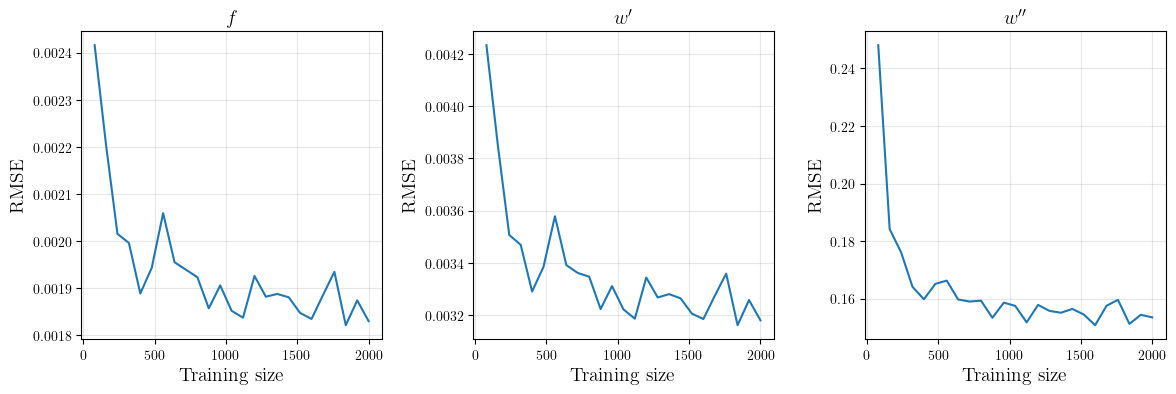

In [18]:
eval_metrics_list = [{key: results[1.0][key]} for results in test_results_list for key in ['RMSE']]
f_error = np.array([list(metrics.values())[0][0] for metrics in eval_metrics_list])
dw_error = np.array([list(metrics.values())[0][1] for metrics in eval_metrics_list])
ddw_error = np.array([list(metrics.values())[0][2] for metrics in eval_metrics_list])
x = 0.8*np.array(range(100, 2501, 100))
x

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].plot(x, f_error)
ax[0].set_title('$f$')
ax[1].plot(x, dw_error)
ax[1].set_title('$w^{\\prime}$')
ax[2].plot(x, ddw_error)
ax[2].set_title('$w^{\\prime\\prime}$')

for a in ax:
    a.set_xlabel('Training size', fontsize=14)
    a.set_ylabel('RMSE', fontsize=14)
    a.grid(True, alpha=0.3)

plt.subplots_adjust(wspace=0.3)

# os.chdir('..')
plt.savefig('figures/PCE_train.svg', bbox_inches='tight')


## 2.1 PCE Evaluation

In [4]:
'''LOAD RESULTS'''
# os.chdir('..')
# os.chdir('models')
os.getcwd()

'/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/notebooks'

In [54]:
# file_list = os.listdir()[:28]
# print(file_list)

# file_id = file_list[12]
# file_list = ['best/1_1/sobol_5000_LS_d2', 'best/1_2/korobov_1000_LS_d2', 'best/1_3/korobov_1000_LS_d2', 'best/1_4/korobov_1000_LS_d2']

os.chdir('..')
os.chdir('models')
os.getcwd()
file_list = os.listdir('new_best')
# file_list = ['best/1_1/rnd_500_LS_d2', 'best/1_2/LHS_500_LS_d2', 'best/1_3_1/rnd_500_LS_d2', 'best/1_3_2/rnd_2500_LS_d2']
file_id = 'new_best/1_3'

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A SINGLE MODEL'''
# # Load test results from pickle file
# with open(f'{file_id}/test_results.pkl', 'rb') as file:
#     test_results = pickle.load(file)

# # Load the pce model from pickle file
# with open(f'{file_id}/pce_model.pkl', 'rb') as file:
#     pce_model = pickle.load(file)

# pce_model_list = [pce_model]

# results = test_results[1.0]
# results # [1.05]

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
r2score_list = []
test_results_list = []
pce_model_list = []
for file_id in file_list:

    # Load test results from pickle file
    with open(f'new_best/{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'new_best/{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)
    
    # test_results_list.append(test_results)
    pce_model_list.append(pce_model)

    # results = test_results[1.0] # [1.05]

    # r2score_list.append(results["R2"])

'''GET TEST RESULTS FROM INCREASED TEST SETS'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = 'test_set_random'
## Load test results
with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

test_results_list = []
# Build a pce constructor for each evaluation, constrained by stretch values
def_min_list = [1.00, 1.05, 1.10, 1.12, 1.14]
def_max_list = [1.05, 1.10, 1.12, 1.14, 1.15]
for i, pce_model in enumerate(pce_model_list[1:2]):
    deformation_min = def_min_list[i+1] # 1.1 + 0.025*i
    deformation_max = def_max_list[i+1] # deformation_min + 0.025
    print(f"i: {i+1}")
    print(f"deformation_min: {deformation_min}")
    print(f"deformation_max: {deformation_max}")
    print(pce_model)
    filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
    pce_constructor = PCEConstructor(df=filtered_df, rnd_inputs=rnd_inputs, y_columns=['lambda_f', 'force', 'dw', 'ddw'])
    # Test each pce, creating a dictionary of test results
    test_results = pce_constructor.test_pce(pce_model)
    # Create a test_result list. From here on, the pipeline is implemented
    test_results_list.append(test_results)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )


i: 1
deformation_min: 1.05
deformation_max: 1.1
{1.0: polynomial([-0.00022398096053297665*q6**2-3.836003986191474e-07*q5*q6-0.002600096908552564*q4*q6-1.1570562687408023e-05*q3*q6+4.742523645732069e-10*q2*q6+1.0084358187202072*q1*q6+0.30851858282973793*q0*q6+2.551061912650617e-09*q5**2+7.328147040173101e-07*q3*q5+8.258231015976148e-07*q4*q5+1.467009848302552e-12*q2*q5-7.066179792299867e-07*q1*q5-0.0003824156383684839*q1*q4-7.04305358997752e-06*q0*q5+0.00011851294486955023*q4**2-5.731150137160207e-06*q3*q4-0.013847307136394283*q0*q4-4.314698783888778e-10*q2*q4+3.5964227176477925e-11*q2*q3+1.1478821212124286e-05*q3**2+0.044341954160967825*q0*q1-0.005932883935853598*q0**2-2.4972906225054946e-05*q1*q3+0.0009309916353369624*q0*q3+5.148359432761219e-11*q1*q2-2.0249153980998405e-17*q2**2-2.237456954342582e-05*q1**2-4.8540510096384124e-09*q0*q2-2.0743729249577906e-06*q5+0.0004922367167988773*q6-3.798640253909342e-05*q3+0.002610991233748495*q4+1.366663224409194e-10*q2-1.0083403008525746*q1-0.30

In [55]:
eval_metrics_list = [{key: results[1.0][key]} for results in test_results_list for key in ['R2', 'RMSE', 'MSE', 'MAE']]
eval_metrics_list

[{'R2': array([0.99999999, 0.96730422, 0.96603483, 0.9369385 ])},
 {'RMSE': array([7.20320606e-07, 8.13330176e-03, 1.39639675e-02, 7.18073279e-01])},
 {'MSE': array([5.18861776e-13, 6.61505976e-05, 1.94992389e-04, 5.15629235e-01])},
 {'MAE': array([4.15707975e-07, 4.02048761e-03, 6.93357728e-03, 3.47393421e-01])}]

In [56]:
pce_id = 0
pce = pce_model_list[pce_id][1.0]
pce

polynomial([-0.00018481674684334493*q6**2+1.0107621241194255e-06*q5*q6-0.002655567465577202*q4*q6+1.6502739299092135e-05*q3*q6-1.7613802380274213e-10*q2*q6+1.0086733552679454*q1*q6+0.3005234213788773*q0*q6-8.18105717706033e-09*q5**2-3.155778117614833e-08*q3*q5-4.918664420272995e-07*q4*q5+3.750833415952095e-12*q2*q5+3.512647607038275e-07*q1*q5-0.00011883742023438844*q1*q4+2.07375205973217e-05*q0*q5+6.195590068784122e-05*q4**2-1.9695425352966184e-05*q3*q4-0.006567765733439482*q0*q4+1.7185753464083998e-12*q2*q4-3.9273568701266623e-10*q2*q3-1.4776968013625976e-06*q3**2+0.017474137556106422*q0*q1-0.028765673756546116*q0**2+2.146250721745867e-05*q1*q3+0.00047312528440361906*q0*q3-7.197880587945734e-11*q1*q2-1.2377279077181499e-15*q2**2+1.7476259195662532e-05*q1**2-7.761124497223056e-09*q0*q2-5.298567011102271e-07*q5+0.00041639419017225343*q6+1.9222574742226898e-05*q3+0.002651955443640887*q4+1.1396685028781797e-09*q2-1.008789052873441*q1-0.2985608671487933*q0+0.9997285167364194,
            3

In [57]:
keys_list = list(pce_model.keys())
key_id = 0
print(f"Stretch: {keys_list[key_id]}")
pce = pce_model[keys_list[key_id]]
results = test_results[keys_list[key_id]]
pce, results

Stretch: 1.0


(polynomial([-0.00022398096053297665*q6**2-3.836003986191474e-07*q5*q6-0.002600096908552564*q4*q6-1.1570562687408023e-05*q3*q6+4.742523645732069e-10*q2*q6+1.0084358187202072*q1*q6+0.30851858282973793*q0*q6+2.551061912650617e-09*q5**2+7.328147040173101e-07*q3*q5+8.258231015976148e-07*q4*q5+1.467009848302552e-12*q2*q5-7.066179792299867e-07*q1*q5-0.0003824156383684839*q1*q4-7.04305358997752e-06*q0*q5+0.00011851294486955023*q4**2-5.731150137160207e-06*q3*q4-0.013847307136394283*q0*q4-4.314698783888778e-10*q2*q4+3.5964227176477925e-11*q2*q3+1.1478821212124286e-05*q3**2+0.044341954160967825*q0*q1-0.005932883935853598*q0**2-2.4972906225054946e-05*q1*q3+0.0009309916353369624*q0*q3+5.148359432761219e-11*q1*q2-2.0249153980998405e-17*q2**2-2.237456954342582e-05*q1**2-4.8540510096384124e-09*q0*q2-2.0743729249577906e-06*q5+0.0004922367167988773*q6-3.798640253909342e-05*q3+0.002610991233748495*q4+1.366663224409194e-10*q2-1.0083403008525746*q1-0.3096161161731105*q0+0.9997624607772218,
             7.

In [58]:
pce_id = 0
results = test_results_list[pce_id][1.0]

predictions = results['predictions']
true_output = results['real_output']

print(f'r2 score: {results["R2"]}')
print(f'mse: {results["MSE"]}')
print(f'mae: {results["MAE"]}')
print(f'rmse: {results["RMSE"]}')
print(len(predictions), len(predictions[predictions < 0]))
# print(predictions[predictions < 0])
# print(true_output[predictions < 0])

r2 score: [0.99999999 0.96730422 0.96603483 0.9369385 ]
mse: [5.18861776e-13 6.61505976e-05 1.94992389e-04 5.15629235e-01]
mae: [4.15707975e-07 4.02048761e-03 6.93357728e-03 3.47393421e-01]
rmse: [7.20320606e-07 8.13330176e-03 1.39639675e-02 7.18073279e-01]
508 0


In [59]:
real_output_list = [results[1.0]['real_output'] for results in test_results_list]
predictions_list = [results[1.0]['predictions'] for results in test_results_list]

# Vstack the arrays in real_output_list
true_output_all = np.vstack(real_output_list)
predictions_all = np.vstack(predictions_list)

In [60]:
true_output_all.shape, predictions_all.shape

((508, 4), (508, 4))

In [61]:
# Get R2 score for true_output_all and predictions_all
R2 = 1 - (np.sum((predictions_all - true_output_all) ** 2, axis=0) / np.sum((true_output_all - np.mean(true_output_all, axis=0)) ** 2, axis=0))
MAE = np.mean(abs(predictions_all - true_output_all), axis=0)
MSE = np.mean(((predictions_all - true_output_all)) ** 2, axis=0)
RMSE = np.sqrt(MSE)
print(f'R2: {R2}')
print(f'MAE: {MAE}')
print(f'MSE: {MSE}')
print(f'RMSE: {RMSE}')


R2: [0.99999999 0.96730422 0.96603483 0.9369385 ]
MAE: [4.15707975e-07 4.02048761e-03 6.93357728e-03 3.47393421e-01]
MSE: [5.18861776e-13 6.61505976e-05 1.94992389e-04 5.15629235e-01]
RMSE: [7.20320606e-07 8.13330176e-03 1.39639675e-02 7.18073279e-01]


<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3215/3492491010.py:2: SyntaxWarning: invalid escape sequence '\l'
  QOI_symbols = ['$\lambda_f$', '$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
/tmp/ipykernel_3215/3492491010.py:2: SyntaxWarning: invalid escape sequence '\p'
  QOI_symbols = ['$\lambda_f$', '$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
/tmp/ipykernel_3215/3492491010.py:2: SyntaxWarning: invalid escape sequence '\p'
  QOI_symbols = ['$\lambda_f$', '$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
/tmp/ipykernel_3215/3492

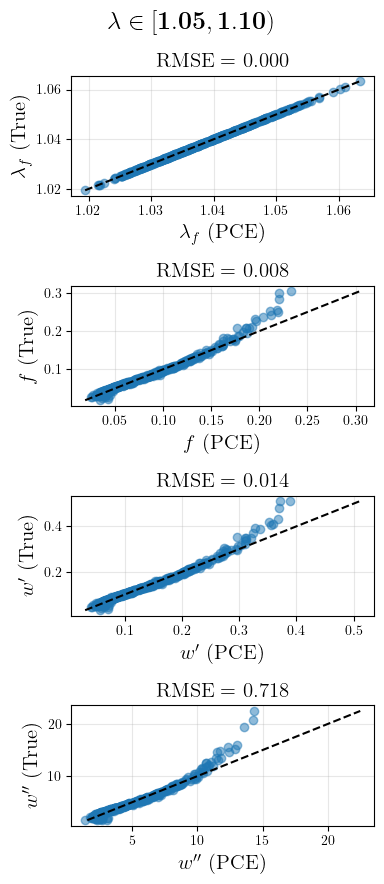

In [62]:
QOI_list = ['lambda_f', 'force', 'dw', 'ddw']
QOI_symbols = ['$\lambda_f$', '$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
fig, axs = plt.subplots(len(QOI_list), 1, figsize=(4, 9))

fig.suptitle('$\mathbf{\lambda \in [1.05,1.10)}$', fontsize=18)

for iQOI in range(len(QOI_list)):
    predictions_plot = predictions_all[:, iQOI]
    true_output_plot = true_output_all[:, iQOI]
    # Sort predictions_plot and true_output_plot
    # sort_indices = np.argsort(true_output_plot)
    # predictions_plot = predictions_plot[sort_indices][:-1]
    # true_output_plot = true_output_plot[sort_indices][:-1]
    axs[iQOI].plot(predictions_plot, true_output_plot, 'o', alpha=0.5)
    axs[iQOI].plot(
        [np.min(true_output_plot), np.max(true_output_plot)],
        [np.min(true_output_plot), np.max(true_output_plot)],
        'k--', alpha=1
    )
    axs[iQOI].set_xlabel(f"{QOI_symbols[iQOI]} (PCE)", fontsize=15)
    axs[iQOI].set_ylabel(f"{QOI_symbols[iQOI]} (True)", fontsize=15)
    # axs[iQOI].set_title(f"$\mathrm{{RMSE}} = $ {results['RMSE'][iQOI]:.3f}", fontsize=15)
    axs[iQOI].set_title(f"$\mathrm{{RMSE}} = $ {RMSE[iQOI]:.3f}", fontsize=15)
    axs[iQOI].grid(True, alpha=0.3)
    # axs[iQOI].set_xlim(np.min(true_output_plot), 0.75*np.max(true_output_plot))
    # axs[iQOI].set_ylim(np.min(true_output_plot), 0.75*np.max(true_output_plot))

plt.tight_layout()

os.chdir('..')
os.chdir('figures')
plt.savefig('new_PCE_eval_2.pdf', bbox_inches='tight')

## 2.2 Uncertainty Quantification

In [63]:
'''LOAD RESULTS'''
# os.chdir('..')
# os.chdir('models')
os.getcwd()

'/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/figures'

In [64]:
# file_list = os.listdir()[:28]
# print(file_list)

# file_id = file_list[12]
# file_list = ['best/1_1/sobol_5000_LS_d2', 'best/1_2/korobov_1000_LS_d2', 'best/1_3/korobov_1000_LS_d2', 'best/1_4/korobov_1000_LS_d2']

os.chdir('..')
os.chdir('models')
os.getcwd()
# file_list = os.listdir('best/1_4_1')
file_list = ['new_best/1_1', 'new_best/1_2', 'new_best/1_3', 'new_best/1_4', 'new_best/1_5']
# file_id = 'best/1_2/LHS_500_LS_d2'

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
r2score_list = []
test_results_list = []
pce_model_list = []
for file_id in file_list:

    # Load test results from pickle file
    with open(f'{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)
    
    # test_results_list.append(test_results)
    pce_model_list.append(pce_model)

    # results = test_results[1.0] # [1.05]

    # r2score_list.append(results["R2"])

'''GET TEST RESULTS FROM INCREASED TEST SETS'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = 'test_set_random'
## Load test results
with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

# for i, pce_model in enumerate(pce_model_list):
#     deformation_min = 1.05 # 1.1 + 0.025*i
#     deformation_max = 1.1 # deformation_min + 0.025
#     print(f"i: {i}")
#     print(f"deformation_min: {deformation_min}")
#     print(f"deformation_max: {deformation_max}")
#     print(pce_model)
#     filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
#     pce_constructor = PCEConstructor(df=filtered_df, rnd_inputs=rnd_inputs, y_columns=['force', 'dw', 'ddw'])
#     Test each pce, creating a dictionary of test results
#     test_results = pce_constructor.test_pce(pce_model)
#     Create a test_result list. From here on, the pipeline is implemented
#     test_results_list.append(test_results)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )

In [65]:
pce_model_list


[{1.0: polynomial([-0.00018481674684334493*q6**2+1.0107621241194255e-06*q5*q6-0.002655567465577202*q4*q6+1.6502739299092135e-05*q3*q6-1.7613802380274213e-10*q2*q6+1.0086733552679454*q1*q6+0.3005234213788773*q0*q6-8.18105717706033e-09*q5**2-3.155778117614833e-08*q3*q5-4.918664420272995e-07*q4*q5+3.750833415952095e-12*q2*q5+3.512647607038275e-07*q1*q5-0.00011883742023438844*q1*q4+2.07375205973217e-05*q0*q5+6.195590068784122e-05*q4**2-1.9695425352966184e-05*q3*q4-0.006567765733439482*q0*q4+1.7185753464083998e-12*q2*q4-3.9273568701266623e-10*q2*q3-1.4776968013625976e-06*q3**2+0.017474137556106422*q0*q1-0.028765673756546116*q0**2+2.146250721745867e-05*q1*q3+0.00047312528440361906*q0*q3-7.197880587945734e-11*q1*q2-1.2377279077181499e-15*q2**2+1.7476259195662532e-05*q1**2-7.761124497223056e-09*q0*q2-5.298567011102271e-07*q5+0.00041639419017225343*q6+1.9222574742226898e-05*q3+0.002651955443640887*q4+1.1396685028781797e-09*q2-1.008789052873441*q1-0.2985608671487933*q0+0.9997285167364194,
      

In [71]:
# Create stretch array
stretch_array = np.linspace(1.00, 1.15, 10)
# Preallocate arrays for mean and std of each QOI
mean_array = np.zeros((len(stretch_array), 4))
std_array = np.zeros((len(stretch_array), 4))

for i, stretch in enumerate(stretch_array):
    if stretch < 1.05:
        pce_model = pce_model_list[0][1.0]
    elif stretch < 1.10:
        pce_model = pce_model_list[1][1.0]
    elif stretch < 1.12:
        pce_model = pce_model_list[2][1.0]
    elif stretch < 1.14:
        pce_model = pce_model_list[3][1.0]
    else:
        pce_model = pce_model_list[4][1.0]
    q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
    aux_poly = cp.E_cond(pce_model, q6, dist=joint_dist)
    mean_array[i, :] = aux_poly(q6=stretch)
    std_array[i, :] = cp.Std(pce_model(*[None, None, None, None, None, None, stretch]), joint_dist)

lambda_f_array = mean_array[:, 0]
force_array = mean_array[:, 1]
dw_array = mean_array[:, 2]
ddw_array = mean_array[:, 3]
lambda_f_std_array = std_array[:, 0]
force_std_array = std_array[:, 1]
dw_std_array = std_array[:, 2]
ddw_std_array = std_array[:, 3]


<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_3215/419251015.py:5: SyntaxWarning: invalid escape sequence '\l'
  ax[0].set_ylabel('$\lambda_f$', fontsize=14)
/tmp/ipykernel_3215/419251015.py:22: SyntaxWarning: invalid escape sequence '\l'
  a.set_xlabel('$\lambda$', fontsize=14)


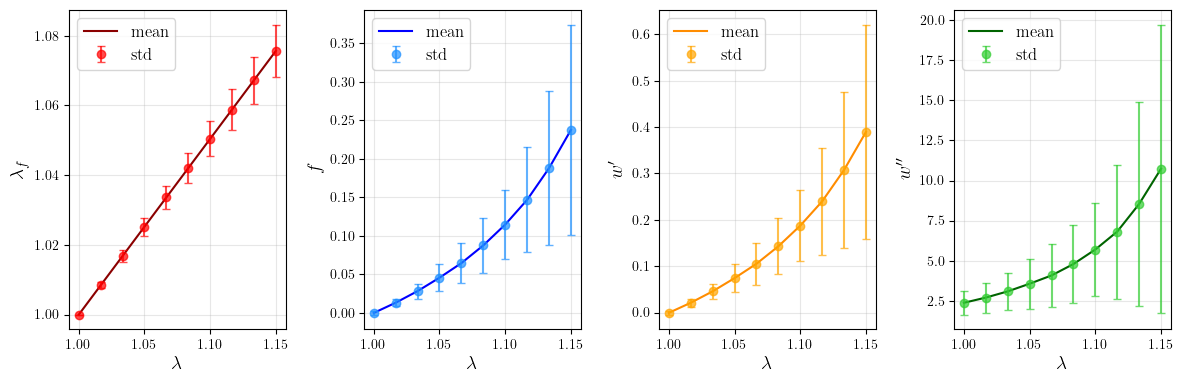

In [72]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4))

ax[0].plot(stretch_array, lambda_f_array, label='mean', color='darkred')
ax[0].errorbar(stretch_array, lambda_f_array, yerr=lambda_f_std_array, fmt='o', label='std', color='red', capsize=3, alpha=0.7)
ax[0].set_ylabel('$\lambda_f$', fontsize=14)

ax[1].plot(stretch_array, force_array, label='mean', color='blue')
# ax[1].plot(stretch_array, force_array + force_std_array, color='blue', linestyle='--', alpha=0.7, label='std')
# ax[1].plot(stretch_array, force_array - force_std_array, color='blue', linestyle='--', alpha=0.7)
ax[1].errorbar(stretch_array, force_array, yerr=force_std_array, fmt='o', label='std', color='dodgerblue', capsize=3, alpha=0.7)
ax[1].set_ylabel('$f$', fontsize=14)

ax[2].plot(stretch_array, dw_array, label='mean', color='darkorange')
ax[2].errorbar(stretch_array, dw_array, yerr=dw_std_array, fmt='o', label='std', color='orange', capsize=3, alpha=0.7)
ax[2].set_ylabel('$w^{\\prime}$', fontsize=14)

ax[3].plot(stretch_array, ddw_array, label='mean', color='darkgreen')
ax[3].errorbar(stretch_array, ddw_array, yerr=ddw_std_array, fmt='o', label='std', color='limegreen', capsize=3, alpha=0.7)
ax[3].set_ylabel('$w^{\\prime\\prime}$', fontsize=14)

for a in ax:
    a.set_xlabel('$\lambda$', fontsize=14)
    a.grid(True, alpha=0.3)
    a.legend(fontsize=12)
plt.tight_layout()

# os.chdir('..')
# os.chdir('figures')
# plt.savefig('PCE_un_quant.svg', bbox_inches='tight')


<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_3215/279972835.py:5: SyntaxWarning: invalid escape sequence '\l'
  ax[0, 0].set_ylabel('$\lambda_f$', fontsize=14)
/tmp/ipykernel_3215/279972835.py:23: SyntaxWarning: invalid escape sequence '\l'
  ax[i, j].set_xlabel('$\lambda$', fontsize=14)


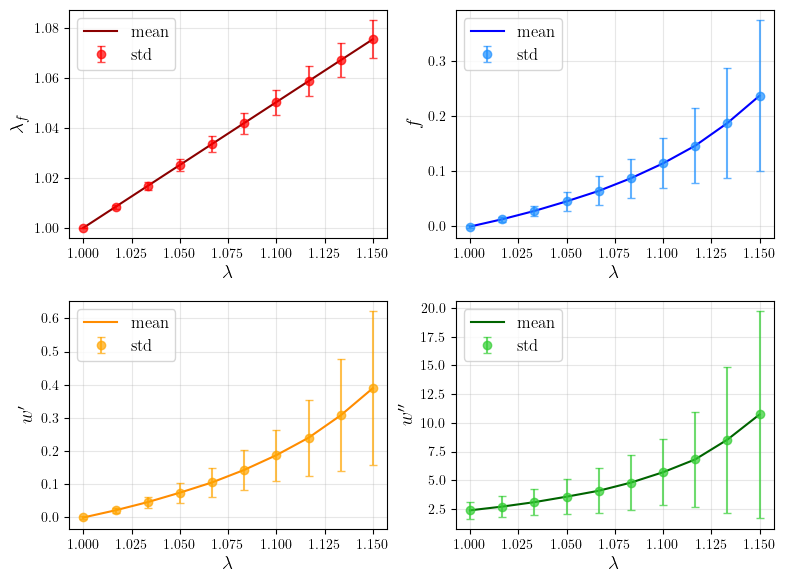

In [74]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0, 0].plot(stretch_array, lambda_f_array, label='mean', color='darkred')
ax[0, 0].errorbar(stretch_array, lambda_f_array, yerr=lambda_f_std_array, fmt='o', label='std', color='red', capsize=3, alpha=0.7)
ax[0, 0].set_ylabel('$\lambda_f$', fontsize=14)

ax[0, 1].plot(stretch_array, force_array, label='mean', color='blue')
# ax[1].plot(stretch_array, force_array + force_std_array, color='blue', linestyle='--', alpha=0.7, label='std')
# ax[1].plot(stretch_array, force_array - force_std_array, color='blue', linestyle='--', alpha=0.7)
ax[0, 1].errorbar(stretch_array, force_array, yerr=force_std_array, fmt='o', label='std', color='dodgerblue', capsize=3, alpha=0.7)
ax[0, 1].set_ylabel('$f$', fontsize=14)

ax[1, 0].plot(stretch_array, dw_array, label='mean', color='darkorange')
ax[1, 0].errorbar(stretch_array, dw_array, yerr=dw_std_array, fmt='o', label='std', color='orange', capsize=3, alpha=0.7)
ax[1, 0].set_ylabel('$w^{\\prime}$', fontsize=14)

ax[1, 1].plot(stretch_array, ddw_array, label='mean', color='darkgreen')
ax[1, 1].errorbar(stretch_array, ddw_array, yerr=ddw_std_array, fmt='o', label='std', color='limegreen', capsize=3, alpha=0.7)
ax[1, 1].set_ylabel('$w^{\\prime\\prime}$', fontsize=14)

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel('$\lambda$', fontsize=14)
        ax[i, j].grid(True, alpha=0.3)
        ax[i, j].legend(fontsize=12)
plt.tight_layout()

os.chdir('..')
os.chdir('figures')
plt.savefig('new_PCE_un_quant.pdf', bbox_inches='tight')

In [77]:
ddw_std_array

array([0.74080139, 0.75528187, 0.76986059, 0.78453207, 0.79929121,
       0.81413324, 0.8290537 , 0.84404843, 0.85911355, 0.87424542,
       0.88944063, 0.904696  , 0.92000851, 0.93537538, 0.95079397,
       0.96626179, 0.98177653, 0.99733599, 1.01293811, 1.02858095,
       1.04426269, 1.05998158, 1.07573602, 1.09152445, 1.10734542,
       1.12319756, 1.13907956, 1.1549902 , 1.17092831, 1.18689278,
       1.20288256, 1.21889665, 1.23493411, 1.25099404, 1.26707559,
       1.28317794, 1.29930032, 1.31544199, 1.33160226, 1.34778044,
       1.55569508, 1.58672887, 1.61800838, 1.64951963, 1.68124959,
       1.71318611, 1.74531785, 1.77763423, 1.81012534, 1.84278197,
       1.87559544, 1.90855769, 1.94166112, 1.97489865, 2.0082636 ,
       2.04174975, 2.07535121, 2.10906248, 2.14287837, 2.17679401,
       2.21080482, 2.24490645, 2.27909484, 2.31336614, 2.34771672,
       2.38214315, 2.41664219, 2.45121077, 2.48584599, 2.5205451 ,
       2.5553055 , 2.59012473, 2.62500044, 2.6599304 , 2.69491

In [76]:
# Get mean and standard deviations for stretch=1.05 and stretch = 1.10
stretch = 1.05
pce_model = pce_model_list[1][1.0]

q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
aux_poly = cp.E_cond(pce_model, q6, dist=joint_dist)
mean = aux_poly(q6=stretch)
std = cp.Std(pce_model(*[None, None, None, None, None, None, stretch]), joint_dist)
print(f"Mean for stretch={stretch}: {mean}")
print(f"Standard deviation for stretch={stretch}: {std}")
# Print standard deviation in percentage of mean value
print(f"Standard deviation in percentage of mean value for stretch={stretch}: {std/mean*100}%")

stretch = 1.1
pce_model = pce_model_list[2][1.0]

q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
aux_poly = cp.E_cond(pce_model, q6, dist=joint_dist)
mean = aux_poly(q6=stretch)
std = cp.Std(pce_model(*[None, None, None, None, None, None, stretch]), joint_dist)
print(f"Mean for stretch={stretch}: {mean}")
print(f"Standard deviation for stretch={stretch}: {std}")
# Print standard deviation in percentage of mean value
print(f"Standard deviation in percentage of mean value for stretch={stretch}: {std/mean*100}%")


Mean for stretch=1.05: [1.02521539 0.04558419 0.07445931 3.57411303]
Standard deviation for stretch=1.05: [0.00252185 0.01745779 0.02987104 1.54540765]
Standard deviation in percentage of mean value for stretch=1.05: [ 0.2459827  38.29790694 40.11726093 43.23891379]%
Mean for stretch=1.1: [1.050431   0.11523096 0.18837912 5.70539362]
Standard deviation for stretch=1.1: [0.00504339 0.05266984 0.08945425 3.3917543 ]
Standard deviation in percentage of mean value for stretch=1.1: [ 0.48012608 45.70806038 47.48629018 59.4482085 ]%


In [70]:
# GET std arrays from cell to plot uncertainty quantification (change stretch_array to len 120)

In [110]:
merged_array = np.concatenate([
    np.array([0.76175794, 0.77667613, 0.79167377, 0.8067464 , 0.82188992,
       0.83710047, 0.85237447, 0.86770855, 0.8830996 , 0.89854469,
       0.91404108, 0.92958619, 0.94517763, 0.96081315, 0.97649062,
       0.99220806, 1.00796359, 1.02375546, 1.03958201, 1.05544168,
       1.07133301, 1.08725459, 1.10320513, 1.11918338, 1.13518818,
       1.15121841, 1.16727304, 1.18335106, 1.19945153, 1.21557357,
       1.23171633, 1.247879  , 1.26406081, 1.28026105, 1.29647903,
       1.31271407, 1.32896557, 1.34523292, 1.36151555, 1.37781293]),
    np.array([1.61505244, 1.649204  , 1.68382078, 1.71887467, 1.75433947,
       1.79019076, 1.82640578, 1.86296332, 1.8998436 , 1.93702819,
       1.9744999 , 2.01224269, 2.05024159, 2.08848261, 2.12695271,
       2.16563966, 2.20453206, 2.24361922, 2.28289113, 2.32233843,
       2.36195232, 2.40172457, 2.44164743, 2.48171363, 2.52191635,
       2.56224916, 2.602706  , 2.64328119, 2.68396936, 2.72476545,
       2.76566467, 2.80666253, 2.84775476, 2.88893733, 2.93020644,
       2.97155847, 3.01299003, 3.05449786, 3.0960789 , 3.13773025]),
    np.array([3.81955711, 3.8956571 , 3.97252406, 4.05011431, 4.12838707,
       4.20730425, 4.28683026, 4.36693183, 4.44757788, 4.52873931,
       4.6103889 , 4.69250118, 4.77505227, 4.8580198 , 4.9413828 ,
       5.02512158, 5.10921767, 5.19365372, 5.2784134 , 5.36348137]),
    np.array([6.69521723, 6.8191954 , 6.94539951, 7.07371042, 7.20401555,
       7.33620865, 7.47018949, 7.60586358, 7.74314193, 7.88194071,
       8.02218101, 8.16378853, 8.30669335, 8.45082966, 8.59613551,
       8.7425526 , 8.890026  , 9.03850402, 9.18793796, 9.33828192])
])
merged_array

array([0.76175794, 0.77667613, 0.79167377, 0.8067464 , 0.82188992,
       0.83710047, 0.85237447, 0.86770855, 0.8830996 , 0.89854469,
       0.91404108, 0.92958619, 0.94517763, 0.96081315, 0.97649062,
       0.99220806, 1.00796359, 1.02375546, 1.03958201, 1.05544168,
       1.07133301, 1.08725459, 1.10320513, 1.11918338, 1.13518818,
       1.15121841, 1.16727304, 1.18335106, 1.19945153, 1.21557357,
       1.23171633, 1.247879  , 1.26406081, 1.28026105, 1.29647903,
       1.31271407, 1.32896557, 1.34523292, 1.36151555, 1.37781293,
       1.61505244, 1.649204  , 1.68382078, 1.71887467, 1.75433947,
       1.79019076, 1.82640578, 1.86296332, 1.8998436 , 1.93702819,
       1.9744999 , 2.01224269, 2.05024159, 2.08848261, 2.12695271,
       2.16563966, 2.20453206, 2.24361922, 2.28289113, 2.32233843,
       2.36195232, 2.40172457, 2.44164743, 2.48171363, 2.52191635,
       2.56224916, 2.602706  , 2.64328119, 2.68396936, 2.72476545,
       2.76566467, 2.80666253, 2.84775476, 2.88893733, 2.93020

## 2.3 Sensitivity Analysis

In [77]:
'''LOAD RESULTS'''
# os.chdir('..')
# os.chdir('models')
os.getcwd()

'/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/figures'

In [79]:
os.chdir('..')
os.chdir('models')
os.getcwd()
file_list = os.listdir('new_best')
# file_list = ['best/1_1/rnd_500_LS_d2', 'best/1_2/LHS_500_LS_d2', 'best/1_3_1/rnd_500_LS_d2', 'best/1_3_2/rnd_2500_LS_d2']
file_id = 'best/1_2/LHS_500_LS_d2'

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
r2score_list = []
test_results_list = []
pce_model_list = []
for file_id in file_list:

    # Load test results from pickle file
    with open(f'new_best/{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'new_best/{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)
    
    # test_results_list.append(test_results)
    pce_model_list.append(pce_model)

'''GET TEST RESULTS FROM INCREASED TEST SETS'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = 'test_set_random'
## Load test results
with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )

In [80]:
joint_dist

J(Normal(mu=0.014, sigma=0.0014), Normal(mu=0.5, sigma=0.05), Normal(mu=38600.0, sigma=3860.0), Uniform(lower=1.9, upper=2.1), Uniform(lower=1.55, upper=1.7), Normal(mu=16.0, sigma=1.6), Uniform(lower=1.0, upper=1.2))

In [81]:
pce_id = 1
pce = pce_model_list[pce_id][1.0]
pce

polynomial([-0.00022398096053297665*q6**2-3.836003986191474e-07*q5*q6-0.002600096908552564*q4*q6-1.1570562687408023e-05*q3*q6+4.742523645732069e-10*q2*q6+1.0084358187202072*q1*q6+0.30851858282973793*q0*q6+2.551061912650617e-09*q5**2+7.328147040173101e-07*q3*q5+8.258231015976148e-07*q4*q5+1.467009848302552e-12*q2*q5-7.066179792299867e-07*q1*q5-0.0003824156383684839*q1*q4-7.04305358997752e-06*q0*q5+0.00011851294486955023*q4**2-5.731150137160207e-06*q3*q4-0.013847307136394283*q0*q4-4.314698783888778e-10*q2*q4+3.5964227176477925e-11*q2*q3+1.1478821212124286e-05*q3**2+0.044341954160967825*q0*q1-0.005932883935853598*q0**2-2.4972906225054946e-05*q1*q3+0.0009309916353369624*q0*q3+5.148359432761219e-11*q1*q2-2.0249153980998405e-17*q2**2-2.237456954342582e-05*q1**2-4.8540510096384124e-09*q0*q2-2.0743729249577906e-06*q5+0.0004922367167988773*q6-3.798640253909342e-05*q3+0.002610991233748495*q4+1.366663224409194e-10*q2-1.0083403008525746*q1-0.3096161161731105*q0+0.9997624607772218,
            7.30

In [82]:
# SOBOL indices

### FULL POLYNOMIALS

# sobol_indices = cp.Sens_m(pce, joint_dist)
# sobol_indices_t = cp.Sens_t(pce, joint_dist)

# FIXED STRETCH

stretch = 1.05

pce_id = 1
pce = pce_model_list[pce_id][1.0]

# Remove stretch from the joint distribution
joint_dist_fix_stretch = joint_dist[:6]

pce_fix_stretch = pce(*[None, None, None, None, None, None, stretch])

sobol_indices = cp.Sens_m(pce_fix_stretch, joint_dist_fix_stretch)
sobol_indices_t = cp.Sens_t(pce_fix_stretch, joint_dist_fix_stretch)
print(f"Sobol indices m: {sobol_indices}")
print(f"Sobol indices t: {sobol_indices_t}")

stretch = 1.15

pce_id = -1
pce = pce_model_list[pce_id][1.0]

pce_fix_stretch = pce(*[None, None, None, None, None, None, stretch])

sobol_indices_2 = cp.Sens_m(pce_fix_stretch, joint_dist_fix_stretch)
sobol_indices_t_2 = cp.Sens_t(pce_fix_stretch, joint_dist_fix_stretch)
print(f"Sobol indices m: {sobol_indices_2}")
print(f"Sobol indices t: {sobol_indices_t_2}")

Sobol indices m: [[7.30265455e-05 1.49360215e-04 1.22856859e-04 5.26297133e-05]
 [9.99919941e-01 9.44325962e-02 8.69948323e-02 1.07297353e-02]
 [5.19092105e-10 4.00976685e-04 3.85466492e-04 4.02201180e-04]
 [1.92664386e-10 4.26046232e-01 3.90717467e-01 4.50544040e-01]
 [5.29353808e-06 1.98325544e-01 2.39258023e-01 2.93282723e-01]
 [1.26853266e-10 6.70230687e-02 6.10946110e-02 5.74226721e-02]]
Sobol indices t: [[7.46532938e-05 1.30424458e-03 1.33144030e-03 1.32356166e-03]
 [9.99921565e-01 1.34385270e-01 1.25680161e-01 1.97974767e-02]
 [1.48347565e-09 8.67817014e-04 8.77533853e-04 1.06948458e-03]
 [2.66319941e-09 6.18476591e-01 5.88424008e-01 6.28365082e-01]
 [5.51349377e-06 3.70019481e-01 4.22629806e-01 4.65830139e-01]
 [1.91656704e-09 8.85688189e-02 8.24837949e-02 7.11802556e-02]]
Sobol indices m: [[7.30549937e-05 5.79096569e-05 6.35517740e-05 6.52213162e-05]
 [9.99920980e-01 1.17648326e-01 1.10804973e-01 5.71175805e-02]
 [7.56023822e-12 3.76729733e-04 3.80420365e-04 7.14505061e-04]
 [

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3215/284608752.py:4: SyntaxWarning: invalid escape sequence '\l'
  QOI_symbol

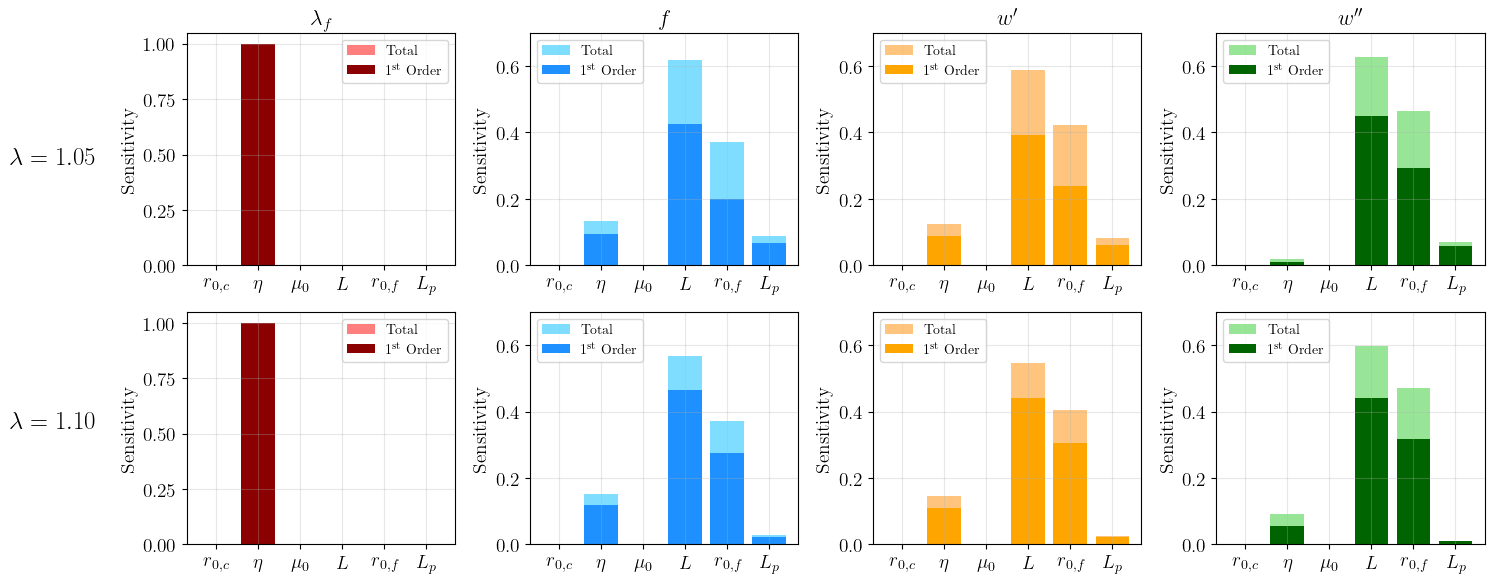

In [85]:
# Create barplots for the sobol indices (first order and total)
import matplotlib.pyplot as plt

QOI_symbols = ['$\lambda_f$', '$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
input_symbols = ['$r_{0,c}$', '$\eta$', '$\mu_0$', '$L$', '$r_{0,f}$', '$L_p$']

fig, axs = plt.subplots(2, len(QOI_symbols), figsize=(14, 6))
color_list = [['red', 'darkred'],['deepskyblue', 'dodgerblue'], ['darkorange', 'orange'], ['limegreen', 'darkgreen']]

fig.text(-0.035, 0.72, '$\lambda=1.05$', ha='center', va='center', fontsize=18)
fig.text(-0.035, 0.28, '$\lambda=1.10$', ha='center', va='center', fontsize=18)

# First order Sobol indices
for i in range(len(QOI_symbols)):
    axs[0, i].bar(range(len(sobol_indices_t[:,i])), sobol_indices_t[:,i], tick_label=input_symbols, alpha=0.5, color=color_list[i][0], label='Total')
    axs[0, i].bar(range(len(sobol_indices[:,i])), sobol_indices[:,i], tick_label=input_symbols, color=color_list[i][1], label='$1^{\mathrm{st}}$ Order')
    axs[0, i].tick_params(axis='x', labelsize=14)
    axs[0, i].tick_params(axis='y', labelsize=14)
    axs[0, i].set_title(f"{QOI_symbols[i]}", fontsize=16)
    axs[0, i].set_ylabel("Sensitivity", fontsize=14)
    if i != 0:
        axs[0,i].set_ylim(0, 0.7)
        axs[0, i].legend(loc='upper left')
    else:
        axs[0, i].legend()
    axs[0,i].grid(True, alpha=0.3)

# Total Sobol indices
for i in range(len(QOI_symbols)):
    axs[1,i].grid(True, alpha=0.3)
    axs[1, i].bar(range(len(sobol_indices_t_2[:,i])), sobol_indices_t_2[:,i], tick_label=input_symbols, alpha=0.5, color=color_list[i][0], label='Total')
    axs[1, i].bar(range(len(sobol_indices_2[:,i])), sobol_indices_2[:,i], tick_label=input_symbols, color=color_list[i][1], label='$1^{\mathrm{st}}$ Order')
    axs[1, i].tick_params(axis='x', labelsize=14)
    axs[1, i].tick_params(axis='y', labelsize=14)
    axs[1, i].set_ylabel("Sensitivity", fontsize=14)
    if i != 0:
        axs[1, i].legend(loc='upper left')
        axs[1,i].set_ylim(0, 0.7)
    else:
        axs[1, i].legend()      

plt.tight_layout()
os.chdir('..')
os.chdir('figures')
plt.savefig('new_PCE_sobol.pdf', bbox_inches='tight')
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_3215/2141405460.py:4: SyntaxWarning: invalid escape sequence '\m'
  fig.text(0.3, 1.012, '$\mathbf{\lambda=1.05}$', ha='center', va='center', fontsize=18)
/tmp/ipykernel_3215/2141405460.py:5: SyntaxWarning: invalid escape sequence '\m'
  fig.text(0.775, 1.012, '$\mathbf{\lambda=1.10}$', ha='center', va='center', fontsize=18)
/tmp/ipykernel_3215/2141405460.py:11: SyntaxWarning: invalid escape sequence '\m'
  axs[i, 0].bar(range(len(sobol_indices[:, i])), sobol_indices[:, i], tick_label=input_symbols, color=color_list[i][1], label='$1^{\mathrm{st}}$ Order')
/tmp/ipykernel_3215

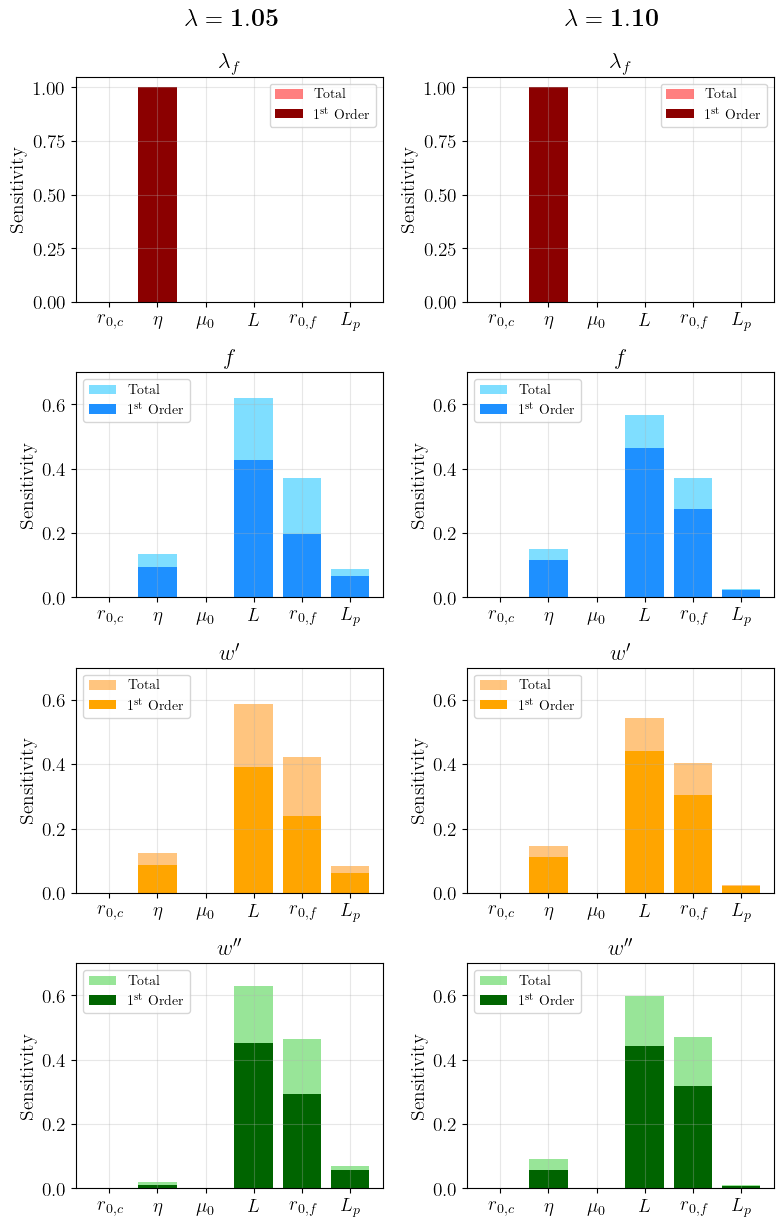

In [103]:
fig, axs = plt.subplots(len(QOI_symbols), 2, figsize=(8, 12))
color_list = [['red', 'darkred'], ['deepskyblue', 'dodgerblue'], ['darkorange', 'orange'], ['limegreen', 'darkgreen']]

fig.text(0.3, 1.012, '$\mathbf{\lambda=1.05}$', ha='center', va='center', fontsize=18)
fig.text(0.775, 1.012, '$\mathbf{\lambda=1.10}$', ha='center', va='center', fontsize=18)

# First order and total Sobol indices for each QOI
for i in range(len(QOI_symbols)):
    # First row: lambda=1.05
    axs[i, 0].bar(range(len(sobol_indices_t[:, i])), sobol_indices_t[:, i], tick_label=input_symbols, alpha=0.5, color=color_list[i][0], label='Total')
    axs[i, 0].bar(range(len(sobol_indices[:, i])), sobol_indices[:, i], tick_label=input_symbols, color=color_list[i][1], label='$1^{\mathrm{st}}$ Order')
    axs[i, 0].tick_params(axis='x', labelsize=14)
    axs[i, 0].tick_params(axis='y', labelsize=14)
    axs[i, 0].set_title(f"{QOI_symbols[i]}", fontsize=16)
    axs[i, 0].set_ylabel("Sensitivity", fontsize=14)
    if i != 0:
        axs[i, 0].set_ylim(0, 0.7)
    axs[i, 0].legend(loc='upper left')
    if i == 0:
        axs[i, 0].legend(loc='upper right')
    axs[i, 0].grid(True, alpha=0.3)

    # Second row: lambda=1.10
    axs[i, 1].bar(range(len(sobol_indices_t_2[:, i])), sobol_indices_t_2[:, i], tick_label=input_symbols, alpha=0.5, color=color_list[i][0], label='Total')
    axs[i, 1].bar(range(len(sobol_indices_2[:, i])), sobol_indices_2[:, i], tick_label=input_symbols, color=color_list[i][1], label='$1^{\mathrm{st}}$ Order')
    axs[i, 1].tick_params(axis='x', labelsize=14)
    axs[i, 1].tick_params(axis='y', labelsize=14)
    axs[i, 1].set_title(f"{QOI_symbols[i]}", fontsize=16)
    axs[i, 1].set_ylabel("Sensitivity", fontsize=14)
    if i != 0:
        axs[i,1].set_ylim(0, 0.7)
    axs[i, 1].legend(loc='upper left')
    if i == 0:
        axs[i, 1].legend(loc='upper right')
    axs[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
os.chdir('..')
os.chdir('figures')
plt.savefig('new_PCE_sobol_transposed.pdf', bbox_inches='tight')
plt.show()


## 2.4 PCE FE Implementation 

In [40]:
# os.chdir('..')
os.getcwd()

'/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers'

In [51]:
# To load
with open('data/abaqus_data_bi.pkl', 'rb') as f:
    abaqus_data = pickle.load(f)

In [ ]:
# ax[0].plot(stretch_array, force_array, label='mean', color='blue')
# # ax[0].plot(stretch_array, force_array + force_std_array, color='blue', linestyle='--', alpha=0.7, label='std')
# # ax[0].plot(stretch_array, force_array - force_std_array, color='blue', linestyle='--', alpha=0.7)
# ax[0].errorbar(stretch_array, force_array, yerr=force_std_array, fmt='o', label='std', color='dodgerblue', capsize=3, alpha=0.7)
# ax[0].set_ylabel('$f$', fontsize=14)

NameError: name 'ax' is not defined

In [52]:
output = np.load('data/output_e_bi.npy')
output_plus = np.load('data/output_plus_bi.npy')
output_minus = np.load('data/output_minus_bi.npy')
output.shape, output_plus.shape, output_minus.shape
output[0], output_plus[0], output_minus[0]

(array([0.        , 0.0015    , 0.003     , 0.00525   , 0.008625  ,
        0.0136875 , 0.02128125, 0.03267188, 0.04767188, 0.06267188,
        0.07767188, 0.09267188, 0.10767187, 0.12267187, 0.13767187,
        0.15000001]),
 array([0.        , 0.0015    , 0.003     , 0.00525   , 0.008625  ,
        0.0136875 , 0.02128125, 0.03267188, 0.04767188, 0.06267188,
        0.07767188, 0.09267188, 0.10767187, 0.12267187, 0.13767187,
        0.15000001]),
 array([0.        , 0.0015    , 0.003     , 0.00525   , 0.008625  ,
        0.0136875 , 0.02128125, 0.03267188, 0.04767188, 0.06267188,
        0.07767188, 0.09267188, 0.10767187, 0.12267187, 0.13767187,
        0.15000001]))

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:50: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:50: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_962/1033712947.py:6: SyntaxWarning: invalid escape sequence '\l'
  stress_symbols = ['$\lambda_{xx}$', '$\lambda_{yy}$', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{xx}$', '$\\sigma_{yy}$', '$\\tau_{xy}$', 't']
/tmp/ipykernel_962/1033712947.py:6: SyntaxWarning: invalid escape sequence '\l'
  stress_symbols = ['$\lambda_{xx}$', '$\lambda_{yy}$', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{xx}$', '$\\sigma_{yy}$', '$\\tau_{xy}$', 't']
/tmp/ipykernel_962/1033712947.py:6: SyntaxWarning: invalid escape sequence '\s'
  stress_symbols = ['$\lambda_{xx}$', '$\lambda_{yy}$', '$\sigma_{\mathrm{VM}}$'

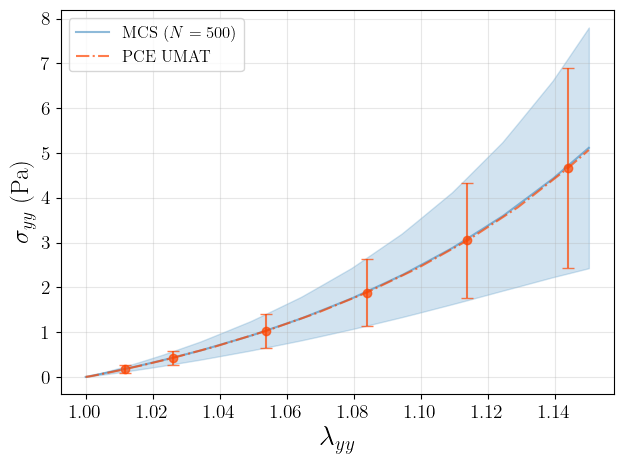

In [45]:
data_list_x = []
data_list_y = []

### N_OUTPUTS = 7 -> u1, u2, s_principal, s11, s22, s12, t

stress_symbols = ['$\lambda_{xx}$', '$\lambda_{yy}$', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{xx}$', '$\\sigma_{yy}$', '$\\tau_{xy}$', 't']
stress_idx = -3
disp_idx = 1
n=500

# Example for range 20, 30, 50, 100, 200!!!
for i in range(n):
    data_list_x.append(abaqus_data[i][disp_idx, :])
    data_list_y.append(abaqus_data[i][stress_idx, :])

# Common x-grid
all_x = np.concatenate(data_list_x)
x_common = np.linspace(all_x.min(), all_x.max(), 500)

interpolated_ys = []
for x, y in zip(data_list_x, data_list_y):
    f = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
    interpolated_ys.append(f(x_common))

data_y_interp = np.vstack(interpolated_ys)

# Create a DataFrame for Seaborn
df = pd.DataFrame(data_y_interp, columns=x_common)
df_melted = df.melt(var_name='x', value_name='y')
df_melted['x'] = df_melted['x'].astype(float) + 1

output_mean = output
# output_plus = output_plus
# output_minus = np.load('data/output_minus_std.npy')
output_std = output_plus[stress_idx, :] - output_mean[stress_idx, :]

x = output_mean[disp_idx, :] + 1
y = output_mean[stress_idx, :]

step = 2
x_err = x[::step][3:]
y_err = y[::step][3:]
std_err = output_std[::step][3:]

plt.figure()
# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label=f'MCS ($N={n}$)', alpha=0.5)
plt.plot(x, y, color='orangered', linestyle='-.', label='PCE UMAT', alpha = 0.7)
plt.errorbar(x_err, y_err, yerr=std_err, fmt='o', color='orangered', capsize = 4, alpha = 0.7)
plt.xlabel("$\lambda_{yy}$", fontsize=20)
plt.ylabel(f"{stress_symbols[stress_idx]} (Pa)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('figures/fem_sig22_uni.pdf', bbox_inches='tight')
plt.show()

In [54]:
data_list_x = []
data_list_y = []

### N_OUTPUTS = 7 -> u1, u2, s_principal, s11, s22, s12, t

stress_symbols = ['a', 'a', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{xx}$', '$\\sigma_{yy}$', '$\\tau_{xy}$', 't']
stress_idx = -3
disp_idx = 1
n_list=[20, 50, 200 , 500]

plt.figure()
# Example for range 20, 50, 100, 200!!!
for n in n_list:
    data_list_x = []
    data_list_y = []
    for i in range(n):
        data_list_x.append(abaqus_data[i][disp_idx, :])
        data_list_y.append(abaqus_data[i][stress_idx, :])

    # Common x-grid
    all_x = np.concatenate(data_list_x)
    x_common = np.linspace(all_x.min(), all_x.max(), 500)

    interpolated_ys = []
    for x, y in zip(data_list_x, data_list_y):
        f = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
        interpolated_ys.append(f(x_common))

    data_y_interp = np.vstack(interpolated_ys)

    # Create a DataFrame for Seaborn
    df = pd.DataFrame(data_y_interp, columns=x_common)
    df_melted = df.melt(var_name='x', value_name='y')
    df_melted['x'] = df_melted['x'].astype(float) + 1

    x0 = x_common[-1] + 1 # some value in x_common
    print(x0)
    print(n, df_melted[df_melted['x'] == x0]['y'].mean())

    # sns.lineplot(data=df_melted, x='x', y='y', errorbar=None, label=f'MCS mean ($N={n}$)', alpha=0.8)

# output_mean = np.load('data/output_econd.npy')
# output_mean = output
# x = output_mean[disp_idx, :] + 1
# y = output_mean[stress_idx, :]


# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
# plt.plot(x, y, color='orangered', linestyle='-.', label='PCE UMAT mean', alpha=0.7)
# plt.xlabel("$\lambda_{yy}$", fontsize=20)
# plt.ylabel(f"{stress_symbols[stress_idx]} (Pa)", fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.legend(fontsize=12)

# plt.tight_layout()
# plt.savefig('figures/fem_compare_sig22_uni.pdf', bbox_inches='tight')
# plt.show()

1.1500000059604645
20 6.803812682628632
1.1500000059604645
50 6.961059322357178
1.1500000059604645
200 7.239902327060699
1.1500000059604645
500 7.258709233760833


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_962/3793493354.py:6: SyntaxWarning: invalid escape sequence '\s'
  stress_symbols = ['a', 'a', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{xx}$', '$\\sigma_{yy}$', '$\\tau_{xy}$', 't']


<Figure size 640x480 with 0 Axes>

In [55]:
output[stress_idx, -1]

np.float64(7.244112968444824)

In [ ]:
'''BIAXIAL'''

### sig22

# 1.1500000059604645
# 20 6.803812682628632
# 1.1500000059604645
# 50 6.961059322357178
# 1.1500000059604645
# 200 7.239902327060699
# 1.1500000059604645
# 500 7.258709233760833

## pce: 7.244112968444824

# pce: REVIEW THIS VALUE

### sigvm

# 1.1500000059604645
# 20 6.827777075767517
# 1.1500000059604645
# 50 6.985574216842651
# 1.1500000059604645
# 200 7.265371943712235
# 1.1500000059604645
# 500 7.284259922027588


'''UNIAXIAL'''

## sig22

# 1.1500000059604645
# 20 4.795787274837494
# 1.1500000059604645
# 50 4.906832323074341
# 1.1500000059604645
# 200 5.0993260216712955
# 1.1500000059604645
# 500 5.113748521327972

# pce: 5.065825462341309

,x,y
0,1.00,0.000000
1,1.00,0.000000
2,1.00,0.000000
3,1.00,0.000000
4,1.00,0.000000
...,...,...
249995,1.15,5.294627
249996,1.15,4.371019
249997,1.15,5.417750
249998,1.15,6.252360


In [32]:
x_common

array([0.        , 0.0003006 , 0.0006012 , 0.0009018 , 0.0012024 ,
       0.00150301, 0.00180361, 0.00210421, 0.00240481, 0.00270541,
       0.00300601, 0.00330661, 0.00360721, 0.00390782, 0.00420842,
       0.00450902, 0.00480962, 0.00511022, 0.00541082, 0.00571142,
       0.00601202, 0.00631263, 0.00661323, 0.00691383, 0.00721443,
       0.00751503, 0.00781563, 0.00811623, 0.00841683, 0.00871744,
       0.00901804, 0.00931864, 0.00961924, 0.00991984, 0.01022044,
       0.01052104, 0.01082164, 0.01112224, 0.01142285, 0.01172345,
       0.01202405, 0.01232465, 0.01262525, 0.01292585, 0.01322645,
       0.01352705, 0.01382766, 0.01412826, 0.01442886, 0.01472946,
       0.01503006, 0.01533066, 0.01563126, 0.01593186, 0.01623247,
       0.01653307, 0.01683367, 0.01713427, 0.01743487, 0.01773547,
       0.01803607, 0.01833667, 0.01863728, 0.01893788, 0.01923848,
       0.01953908, 0.01983968, 0.02014028, 0.02044088, 0.02074148,
       0.02104209, 0.02134269, 0.02164329, 0.02194389, 0.02224

## 2.5 UEL Validation

In [9]:
os.chdir('..')
os.chdir('data')
os.getcwd()


'/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/data'

In [ ]:
uel_files = os.listdir('uel_results')
uel_files

# u1, u2, svm, s11, s22, s12, t
# u1, u1, u2, uvarm, t

biaxial = np.load(os.path.join('uel_results', uel_files[0]))
biaxial_uel = np.load(os.path.join('uel_results', uel_files[1]))
shear = np.load(os.path.join('uel_results', uel_files[2]))
shear_uel = np.load(os.path.join('uel_results', uel_files[3]))
uniaxial = np.load(os.path.join('uel_results', uel_files[4]))
uniaxial_uel = np.load(os.path.join('uel_results', uel_files[5]))

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_942/1739726547.py:5: SyntaxWarning: invalid escape sequence '\l'
  axs[0].set_xlabel('$\lambda_{yy}$', fontsize=20)
/tmp/ipykernel_942/1739726547.py:6: SyntaxWarning: invalid escape sequence '\s'
  axs[0].set_ylabel('$\sigma_{yy}$ (Pa)', fontsize=18)
/tmp/ipykernel_942/1739726547.py:13: SyntaxWarning: invalid escape sequence '\g'
  axs[1].set_xlabel('$\gamma$', fontsize=20)
/tmp/ipykernel_942/1739726547.py:21: SyntaxWarning: invalid escape sequence '\l'
  axs[2].set_xlabel('

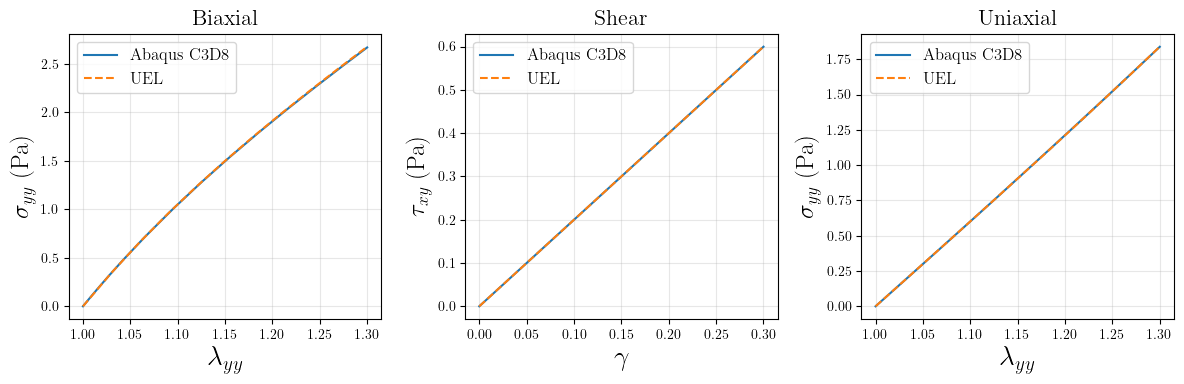

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(biaxial[1, :]+1, biaxial[-3, :], label='Abaqus C3D8', alpha=1)
axs[0].plot(biaxial_uel[2, :]+1, biaxial_uel[-2, :], label='UEL', alpha=1, linestyle='--')
axs[0].set_xlabel('$\lambda_{yy}$', fontsize=20)
axs[0].set_ylabel('$\sigma_{yy}$ (Pa)', fontsize=18)
axs[0].set_title('Biaxial', fontsize=16)
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=12)

axs[1].plot(shear[0, :], shear[-2, :], label='Abaqus C3D8', alpha=1)
axs[1].plot(shear_uel[0, :], shear_uel[-2, :], label='UEL', alpha=1, linestyle='--')
axs[1].set_xlabel('$\gamma$', fontsize=20)
axs[1].set_ylabel('$\\tau_{xy}$ (Pa)', fontsize=18)
axs[1].set_title('Shear', fontsize=16)
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=12)

axs[2].plot(uniaxial[1, :]+1, uniaxial[-3, :], label='Abaqus C3D8', alpha=1)
axs[2].plot(uniaxial_uel[2, :]+1, uniaxial_uel[-2, :], label='UEL', alpha=1, linestyle='--')
axs[2].set_xlabel('$\lambda_{yy}$', fontsize=20)
axs[2].set_ylabel('$\sigma_{yy}$ (Pa)', fontsize=18)
axs[2].set_title('Uniaxial', fontsize=16)
axs[2].grid(True, alpha=0.3)
axs[2].legend(fontsize=12)

plt.tight_layout()

os.chdir('..')
os.chdir('figures')
plt.savefig('fem_compare_uel.pdf', bbox_inches='tight')
plt.show()

-------------------------------------------------------------------------

-------------------------------------------------------------------------

-------------------------------------------------------------------------

-------------------------------------------------------------------------

In [23]:
'''SIMPLE EXAMPLE OF PCE FOR VECTOR OUTPUTS'''

import numpy as np
import chaospy
import sklearn.linear_model

# Define random seed
np.random.seed(0)

# Define the joint distribution
joint_dist = chaospy.J(chaospy.Normal(0, 1), chaospy.Uniform(-1, 1))

# Generate polynomials using the joint distribution
polynomials = chaospy.generate_expansion(2, joint_dist)

# Define the collocation nodes (abscissas) with shape (D, K) = (n_rnd_inputs, n_samples)
abscissas = np.array([[-1, -1, 1, 1],  
                      [-1, 1, -1, 1], 
                      [5, -0, -0, 0]])

# Define the model evaluations (evals) with shape (K, n) = (n_samples, n_outputs)
# Here we obtain 2 polynomials (n=2)
evals = np.array([[1, 2, 2, 4, 5, 6], 
                  [1, 2, 2, 4, 5, 6], 
                  [1, 2, 3, 4, 5, 6], 
                  [1, 2, 3, 4, 5, 6]])

# Fit the polynomial chaos expansion using linear regression
fitted_polynomials = chaospy.fit_regression(polynomials, abscissas, evals)

# Print the fitted polynomials
print(fitted_polynomials)

# Evaluate the fitted polynomials at new points
new_abscissas = np.array([[-1, -1, 1, 1], 
                          [-1, 1, -1, 1], 
                          [-1, 1, -1, 1]])# , [-1, 1, -1, 1], [5, -0, -0, 0]])
predictions = fitted_polynomials(*abscissas)

print(f"Predictions: {predictions}")
print(predictions.shape)

[0.46153846153846195*q1**2+2.220446049250313e-16*q0*q1+1.6653345369377348e-16*q1+0.5384615384615387
 0.9230769230769239*q1**2+4.440892098500626e-16*q0*q1+3.3306690738754696e-16*q1+1.0769230769230773
 1.1538461538461546*q1**2+7.771561172376096e-16*q0*q1+5.551115123125783e-16*q1+0.49999999999999967*q0+1.3461538461538465
 1.8461538461538478*q1**2+8.881784197001252e-16*q0*q1+6.661338147750939e-16*q1+2.1538461538461546
 2.30769230769231*q1**2+1.1102230246251565e-15*q0*q1+2.692307692307694
 2.76923076923077*q1**2+1.3322676295501878e-15*q0*q1+4.440892098500626e-16*q1+8.881784197001252e-16*q0+3.23076923076923]
Predictions: [[1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [2. 2. 3. 3.]
 [4. 4. 4. 4.]
 [5. 5. 5. 5.]
 [6. 6. 6. 6.]]
(6, 4)


In [19]:
import chaospy as cp
import numpy as np

# 1. Define the input distribution (example: 2 independent uniform variables)
dist = cp.Iid(cp.Uniform(0, 1), 4)

# 2. Generate samples (N is number of samples, d is number of variables)
N = 100
samples = dist.sample(N, rule="halton")  # shape: (d, N)

# 3. Evaluate your model for all samples
#    Assume model returns shape (outputs, N)
def model(x):
    # Example: two outputs
    return np.array([
        np.cos(x[0]) + x[1],         # output 1
        10**5 * x[0] * np.sin(x[1])  # output 2
    ])

evals = np.array([model(samples[:, i]) for i in range(N)])  # shape: (outputs, N)

# 4. Define a PCE basis (order=p, d variables)
order = 3
expansion = cp.generate_expansion(order, dist)

# 5. Evaluate the basis at sample locations
# poly_evals = expansion(*samples)  # shape: (num_basis, N)
print(f"samples shape: {samples.shape}, evals shape: {evals.shape}")


# 6. Fit the PCE coefficients in matrix form (multi-output)
#    evals: shape (outputs, N) => columns are samples, rows are outputs
#    poly_evals: shape (num_basis, N)
pce = cp.fit_regression(expansion, samples, evals)

# 7. To evaluate the PCE for new samples:
new_samples = dist.sample(10)
pce_output = pce(*new_samples)
true_output = model(new_samples)  # shape: (outputs, num_new_samples)

pce_output, true_output, pce(*new_samples).shape # shape: (outputs, num_new_samples)

# 8. Each output (row) in `coeffs` or `pce_evals` corresponds to a 
# different output variable.

# Compare 

samples shape: (4, 100), evals shape: (100, 2)


(array([[1.24063585e+00, 9.12802568e-01, 1.38563480e+00, 1.52760224e+00,
         1.04945451e+00, 1.12085051e+00, 1.32505815e+00, 1.62774225e+00,
         1.58230129e+00, 1.36505599e+00],
        [1.34529450e+04, 2.33295293e+04, 4.48144515e+04, 7.20847500e+04,
         1.37879613e+03, 3.62852796e+04, 3.83665542e+03, 3.41528306e+04,
         1.03728351e+03, 4.15465085e+04]]),
 array([[1.24079775e+00, 9.12569934e-01, 1.38546534e+00, 1.52751401e+00,
         1.04926922e+00, 1.12062791e+00, 1.32501292e+00, 1.62787720e+00,
         1.58262455e+00, 1.36497381e+00],
        [1.35403563e+04, 2.31411300e+04, 4.48432660e+04, 7.18988508e+04,
         1.30785075e+03, 3.62466659e+04, 3.98572246e+03, 3.41850058e+04,
         9.70775589e+02, 4.15522810e+04]]),
 (2, 10))

In [ ]:
'''EXAMPLE OF USING MULTIPROCESSING FOR SIMULATIONS'''

from concurrent.futures import ProcessPoolExecutor
import pandas as pd

# Function to run a single simulation
def run_single_simulation(iSample, mat_props_manager, simulation):
    print(f"Running simulation for sample {iSample}")
    mat_props = mat_props_manager.get_material_props(iSample)
    iResults = simulation.run_umat(mat_props)
    print(f"Simulation for sample {iSample} completed.")
    return pd.DataFrame([iResults])

# Parallelized code
# Create empty dataframe for results
df_results = pd.DataFrame()

# Specify the number of CPUs to use
num_cpus = 4  # Replace with the desired number of CPUs

# Use ProcessPoolExecutor for parallel execution
with ProcessPoolExecutor(max_workers=num_cpus) as executor:
    # Submit tasks for each sample
    futures = [executor.submit(run_single_simulation, iSample, self.mat_props_manager, self.simulation)
               for iSample in range(self.n_samples)]
    
    # Collect results as they complete
    for future in futures:
        df_results = pd.concat([df_results, future.result()], axis=0, ignore_index=True)

# Save results to csv
self.simulation.save_results(df_results, self.mat_props_manager.study_props)
print("Study completed.")

In [ ]:
'''TESTING BRENTS METHOD FOR FILAMENT RELATIONS'''

import numpy as np
from scipy.optimize import fsolve, brentq

# Constants (replace with your actual values)
lambda_ = 1.3
lambda_0 = 1.0
r0 = 1.63
L = 1.96
mu0 = 38600.0
beta = 0.5
B0 = 294.0 * 16.0 * 1.38065e-5

# Define the function G(f)
def G(f):
    lhs = (lambda_ * lambda_0 * r0) / L
    aux1 = f / mu0
    aux2 = L**2 / (np.pi**2 * B0)
    num = (1 + 2*aux1) * (1 + aux1)**beta * (1 - r0/L)
    denom = (1 + f*aux2 + f*aux1*aux2)**beta
    rhs = 1 + aux1 - num / denom
    return lhs - rhs

# Solve G(f) = 0 starting from an initial guess
f_solution = fsolve(G, x0=0.1)
print("Solution fsolve: f =", f_solution[0])
b_solution = brentq(G, 0., 1.e20, xtol = 2e-12, maxiter = 100)
print("Solution brentq: f =", b_solution)

Solution fsolve: f = 3186.1201600065315
Solution brentq: f = 3186.1201600065347
